## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [3]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.0
    Uninstalling sentence-transformers-5.1.0:
      Successfully uninstalled sentence-transformers-5.1.0
ERROR: pip'

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# To create embeddings
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sentence_transformers import SentenceTransformer, InputExample

# To build classifier models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Garbage collector
import gc

# Import TensorFlow and Keras for deep learning model building.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from torch.utils.data import DataLoader
from sentence_transformers import losses

# To handle class imbalance
from imblearn.over_sampling import SMOTE


# Setting column to the maximum column width as per the data
pd.set_option('max_colwidth', None)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set a random seed for reproducibility
my_seed = 7
np.random.seed(my_seed)

## **Loading the dataset**

In [3]:
# Load the dataset from the specified path into a pandas DataFrame
df_stock_news = pd.read_csv('stock_news.csv')

# Display the first 5 rows of the DataFrame to verify the data loading
df_stock_news.head(5)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


* Data looks good! Although some content look truncated ...
* Multiple news on the same date, ok

## **Data Overview**

#### Data structure

In [4]:
# Display the number of rows and columns in the DataFrame
print("Number of rows:", df_stock_news.shape[0])
print("Number of columns:", df_stock_news.shape[1])

Number of rows: 349
Number of columns: 8


In [5]:
# Display column names, their data types, and the number of non-null entries
df_stock_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


* Ok, so we don't have null values. However, Date column is an object. Let's change it to Datetime

In [6]:
# Convert the 'Date' column to datetime objects
df_stock_news['Date'] = pd.to_datetime(df_stock_news['Date'], format='%Y-%m-%d')

# Display the data types to verify the conversion
print(df_stock_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB
None


#### Check duplicate rows

In [7]:
# Check for duplicate rows
print("Number of duplicate rows:", df_stock_news.duplicated().sum())

# Remove duplicate rows, keeping the first occurrence
df_stock_news.drop_duplicates(keep='first', inplace=True)

# Verify the number of rows after removing duplicates
print("Number of rows after removing duplicates:", df_stock_news.shape[0])

# reseting the index of the dataframe
df_stock_news = df_stock_news.reset_index(drop = True)

Number of duplicate rows: 0
Number of rows after removing duplicates: 349


* Ok, no duplicates

## **Exploratory Data Analysis**

### **Univariate Analysis**

#### Distribution analysis of numerical columns

In [8]:
# Analyze Numerical Columns

# Calculate and display descriptive statistics for the numerical columns
print("Descriptive Statistics for Numerical Columns:")
display(df_stock_news[['Open', 'High', 'Low', 'Close', 'Volume', 'Label']].describe())

Descriptive Statistics for Numerical Columns:


,Open,High,Low,Close,Volume,Label
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000


* The mean value is very similar for Open/High/Low/Close values
* The mean volume is around 128M shares, min value is 45M and max value is 244M. So we have high variability. We will see the **bullish** and **bearish** market days.
* Let's show their distributions ...

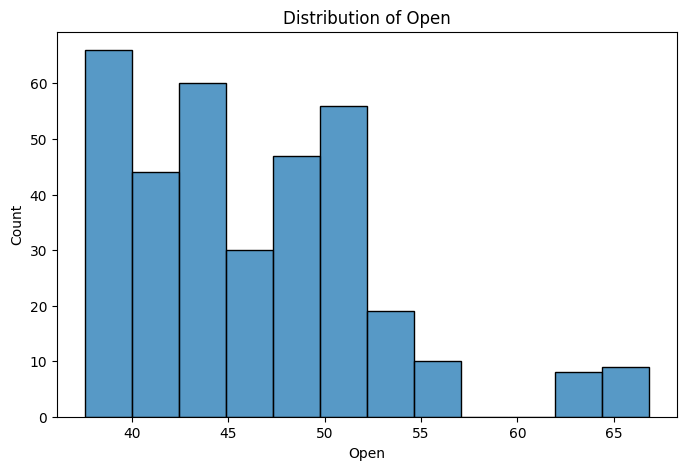

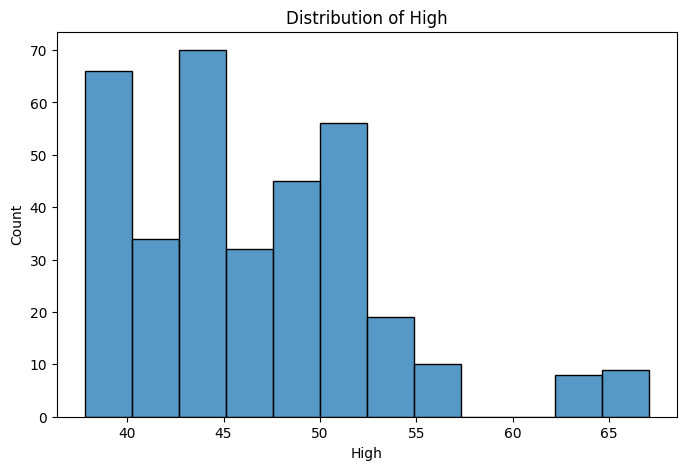

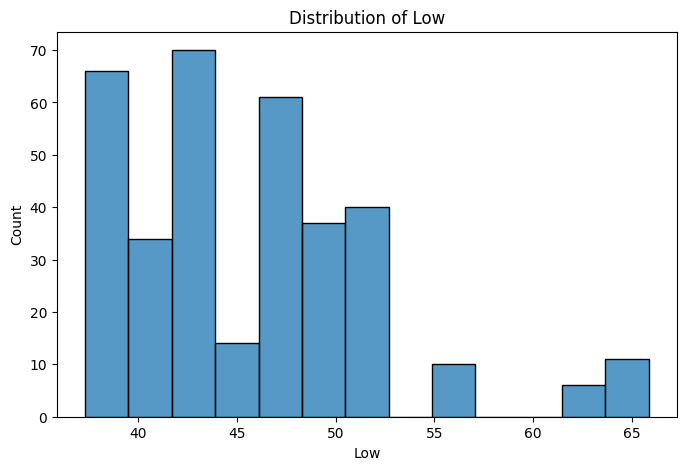

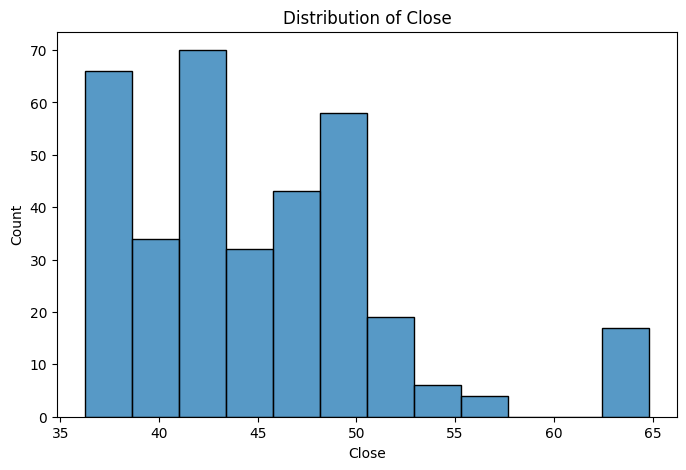

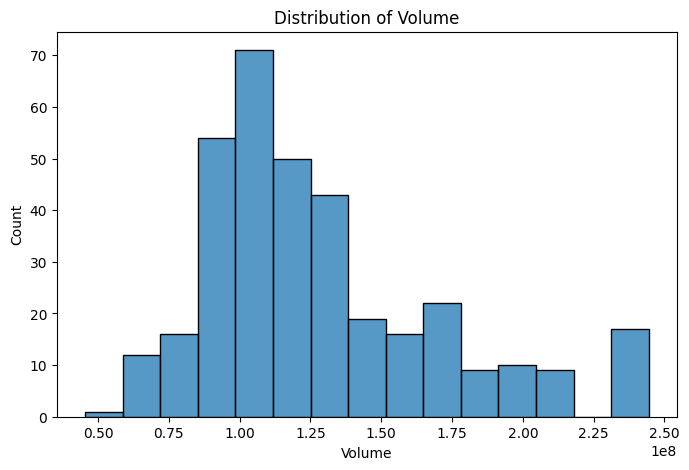

In [9]:
# List of numerical columns to visualize
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Plot histograms for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 5))  # Create a new figure for each plot with a specified size
    sns.histplot(df_stock_news[col]) # Generate a histogram for the current numerical column
    plt.title(f'Distribution of {col}') # Add a title to the histogram indicating the column name
    plt.show() # Display the generated histogram

*   The distributions of 'Open', 'High', 'Low', and 'Close' show a similar pattern, with multiple peaks, suggesting potential changes in stock price trends over time, with some days with significantly higher stock prices.
*   The distribution of 'Volume' appears somewhat skewed to the right, with a concentration of trading volumes around the mean and some occurrences of much higher volumes.


#### Distribution analysis of the categorical column "Label"

Value counts for 'Label' column:
Label
 0    170
-1     99
 1     80
Name: count, dtype: int64


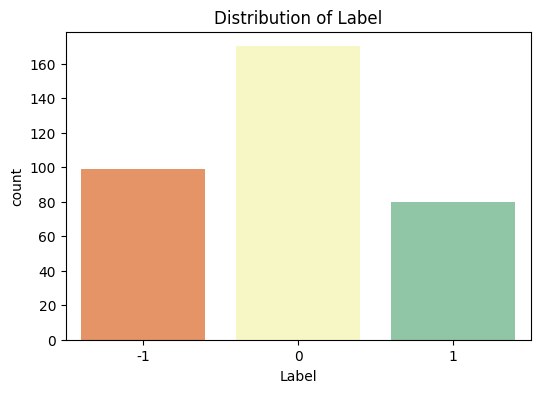

In [10]:
# Plot count plot for 'Label' column
plt.figure(figsize=(6, 4)) # Create a new figure

# Print the value counts for the 'Label' column
print("Value counts for 'Label' column:")
print(df_stock_news['Label'].value_counts())

sns.countplot(x=df_stock_news['Label'], palette="Spectral") # Generate a count plot
plt.title('Distribution of Label') # Add a title
plt.show() # Display the plot

*   The distribution of the 'Label' column is imbalanced, with the '0' category (neutral sentiment) being significantly more frequent than '-1' (negative) and '1' (positive).
* I should take care of this class imbalance during model building, by setting the 'stratify' parameter to maintain some balance between classes in the train_test sets.

#### Distribution analysis of the lenght of text column "News"

Descriptive Statistics for News Length:


,News_Length
count,349.000000
mean,311.237822
std,39.079467
min,110.000000
25%,290.000000
50%,315.000000
75%,336.000000
max,394.000000


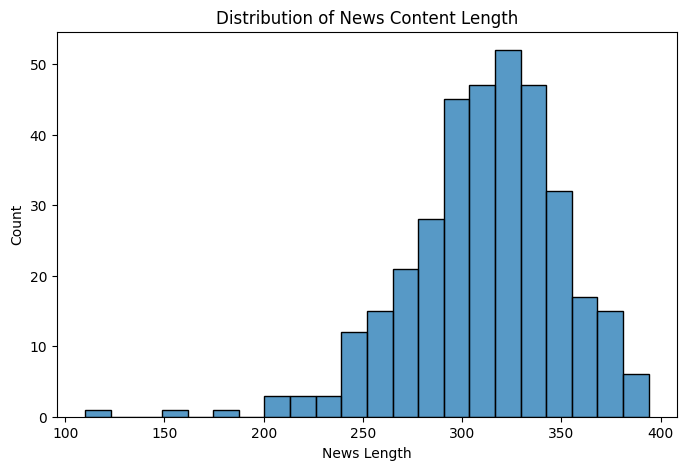

In [11]:
# Compute the string length of the 'News' column
df_stock_news['News_Length'] = df_stock_news['News'].str.len()

# Display descriptive statistics for the news length
print("Descriptive Statistics for News Length:")
display(df_stock_news['News_Length'].describe().T)

# Plot a histogram for the news length distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_stock_news['News_Length'])
plt.title('Distribution of News Content Length')
plt.xlabel('News Length')
plt.ylabel('Count')
plt.show()

* There is a normal distribution with some left skewness on a few articles whose length is smaller than 200 characters. Let's see if there is something special with them.

In [12]:
# Print news articles with a length smaller than 200 characters
print("News articles with length less than 200 characters:")
df_stock_news[(df_stock_news['News_Length'] < 200)]['News']

News articles with length less than 200 characters:


,News
114,"IBM's stock price increased after hours due to better-than-expected earnings and revenue, with its cloud computing business contributing positively."
200,"NVIDIA's stock price surged in premarket trade, up by 8.06% at 8:06 AM ET or 13:06 GMT, following the company's forecast for better-than-expected sales during the current fiscal year."
251,"Tesla's CEO Elon Musk faces SEC scrutiny again for tweets without pre-approval, causing a slip in TSLA stock."


* Ok, no special observations on these small length news.

Let's see the news with the largest length...

In [13]:
# Print news articles with a length = 394 characters (max value)
print("News articles with length = 394 characters:")
df_stock_news[(df_stock_news['News_Length'] == 394)]['News']

News articles with length = 394 characters:


,News
303,"Apple has nearly doubled the number of suppliers using clean energy for production, including major iPhone manufacturers Hon Hai Precision Industry and Taiwan Semiconductor Manufacturing. The companies are part of Apple's initiative to reduce its carbon footprint by encouraging suppliers to build their own renewable energy projects or sign power purchase agreements with new renewable energy"


* Ok, seems that the article included a complete paragraph about Apple. No worries.

Let's go to the Bivariate analysis now.

### **Bivariate Analysis**

#### Correlation analysis

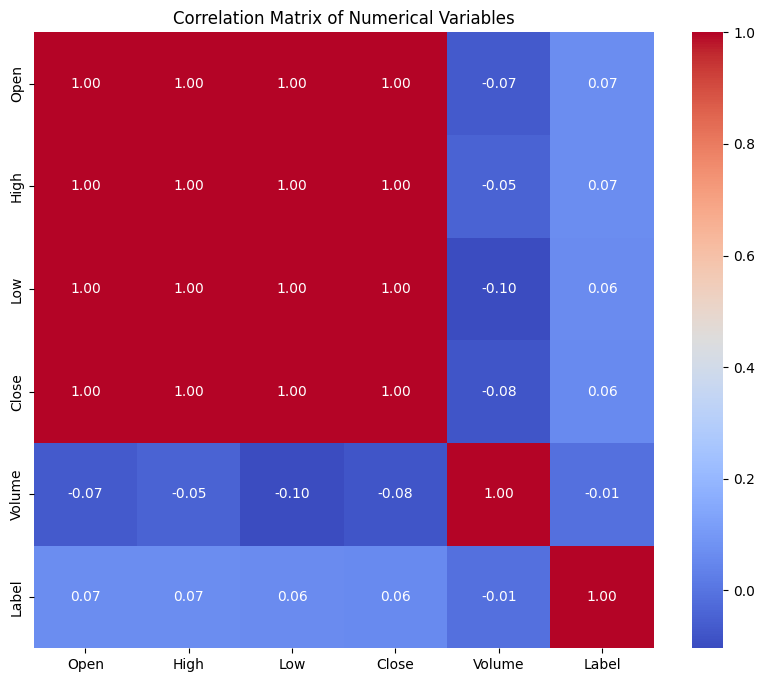

In [14]:
# Calculate the correlation matrix
correlation_matrix = df_stock_news[['Open', 'High', 'Low', 'Close', 'Volume', 'Label']].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

* As expected, Open, High, Low and Close columns are very correlated since they all represent the same stock price at different times.
* Let's get more details about the relationship between Volume, stock prices, and values of Label

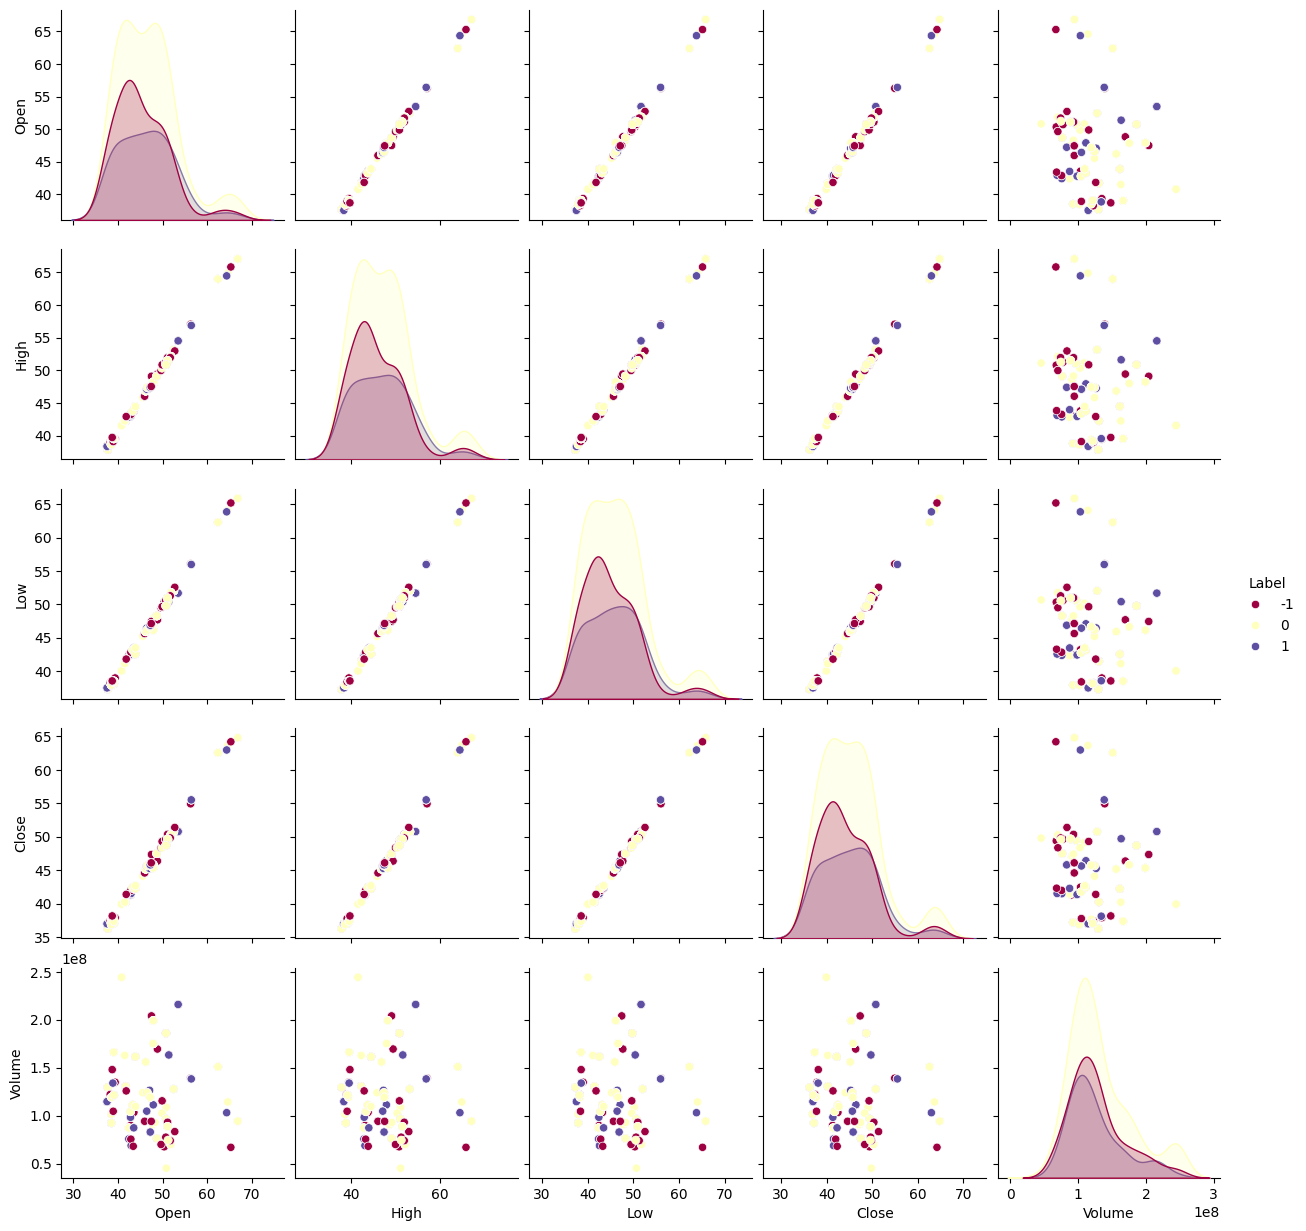

In [15]:
# Create the pair plot
sns.pairplot(data=df_stock_news, vars=['Open', 'High', 'Low', 'Close', 'Volume'], hue='Label', palette='Spectral')
plt.show()

* Disregarding the value of Label, we can see the linear relationship between the several prices columns,. This was expected from the correlation heatmap.
* There is no clear difference in data distribution in the pair-plot between Volume and Prices. It's like a normal cloud with some outliers.
* Coloured plots for Sentiment label seem normally distributed. It doesn't look a clear difference for positive labeled news.

Let's see the boxplots to explore further details.

#### Sentiment to Volume

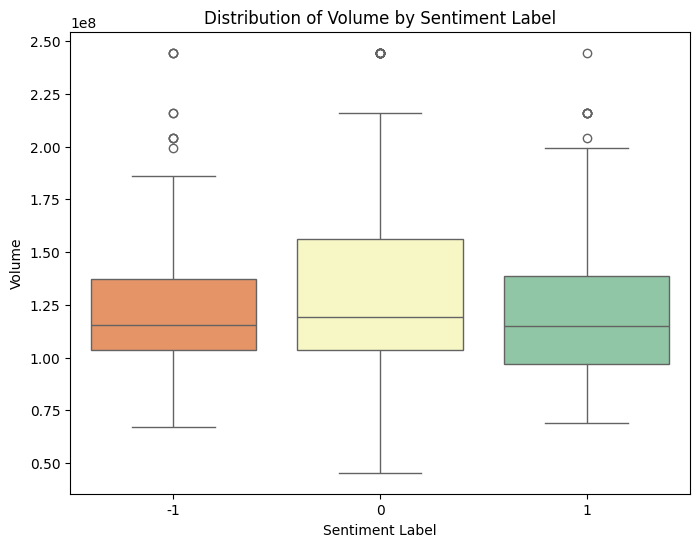

In [16]:
# Plot the distribution of 'Volume' for each 'Label' value
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_stock_news, x='Label', y='Volume', palette='Spectral')
plt.title('Distribution of Volume by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Volume')
plt.show()

* The Volume median and the entire Interquartile Range look similar for the three values of Sentiment label. So, no special treatment.

#### Sentiment to Prices

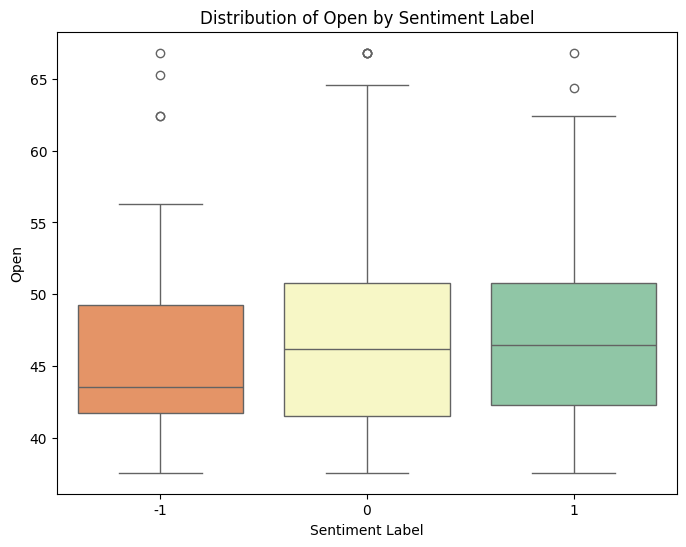

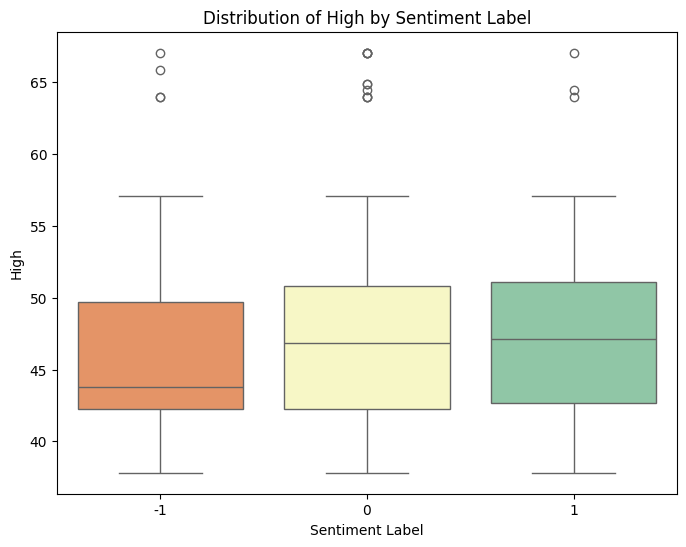

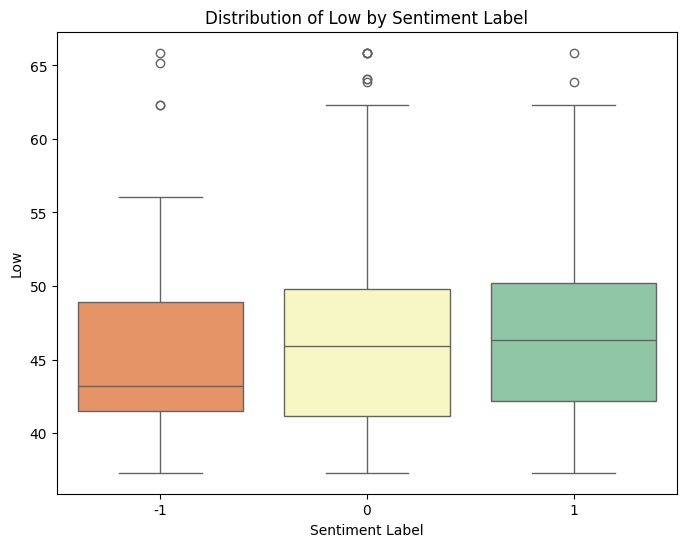

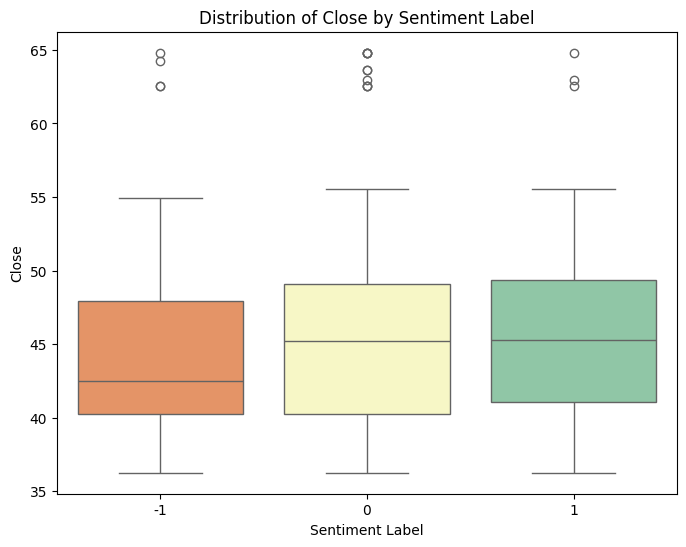

In [17]:
# Plot the distribution of Open, High, Low, and Close by Sentiment Label
numerical_cols_price = ['Open', 'High', 'Low', 'Close']

for col in numerical_cols_price:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_stock_news, x='Label', y=col, palette='Spectral')
    plt.title(f'Distribution of {col} by Sentiment Label')
    plt.xlabel('Sentiment Label')
    plt.ylabel(col)
    plt.show()

* **For all prices, the median is higher when sentiment is Neutral (0) or Positive (1)**

This is a relevant finding! Because we can predict that having positive news may be correlated to higher prices!

#### Volume to Prices grouped by Sentiment label

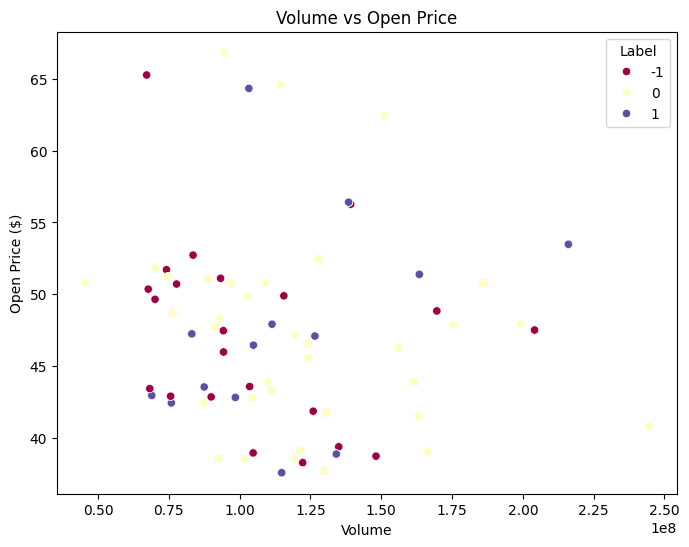

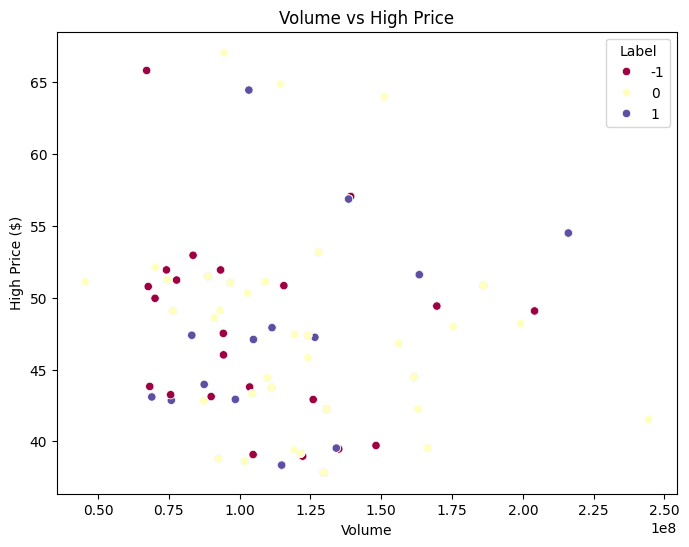

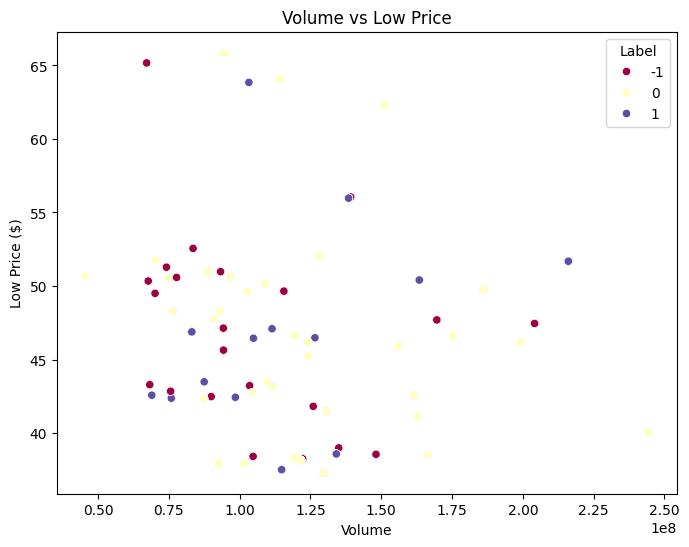

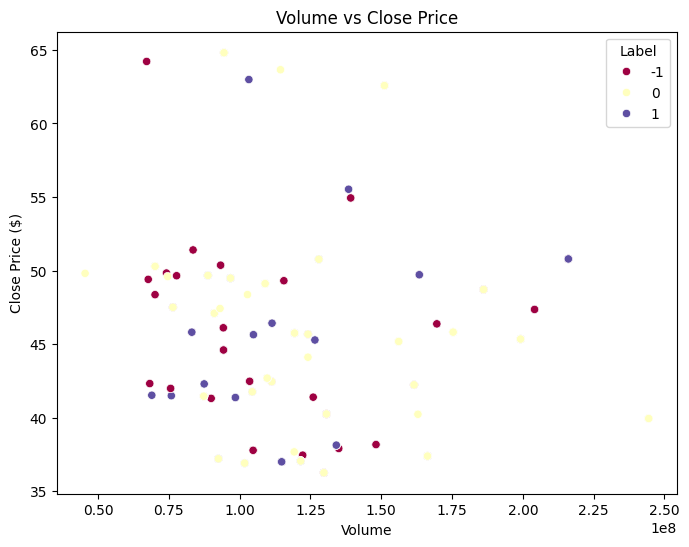

In [18]:
# Plot Volume versus Open, High, Low, Close prices
price_cols = ['Open', 'High', 'Low', 'Close']

for col in price_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_stock_news, x='Volume', y=col, hue='Label', palette='Spectral')
    plt.title(f'Volume vs {col} Price')
    plt.xlabel('Volume')
    plt.ylabel(f'{col} Price ($)')
    plt.show()

* No special findings here. As seen in the multi-plot, distribution seems normal.
* So far, we only have the Sentiment-to-prices relationship as relevant.

Now, let's see the time effect on prices.

#### Date to Prices time series analysis

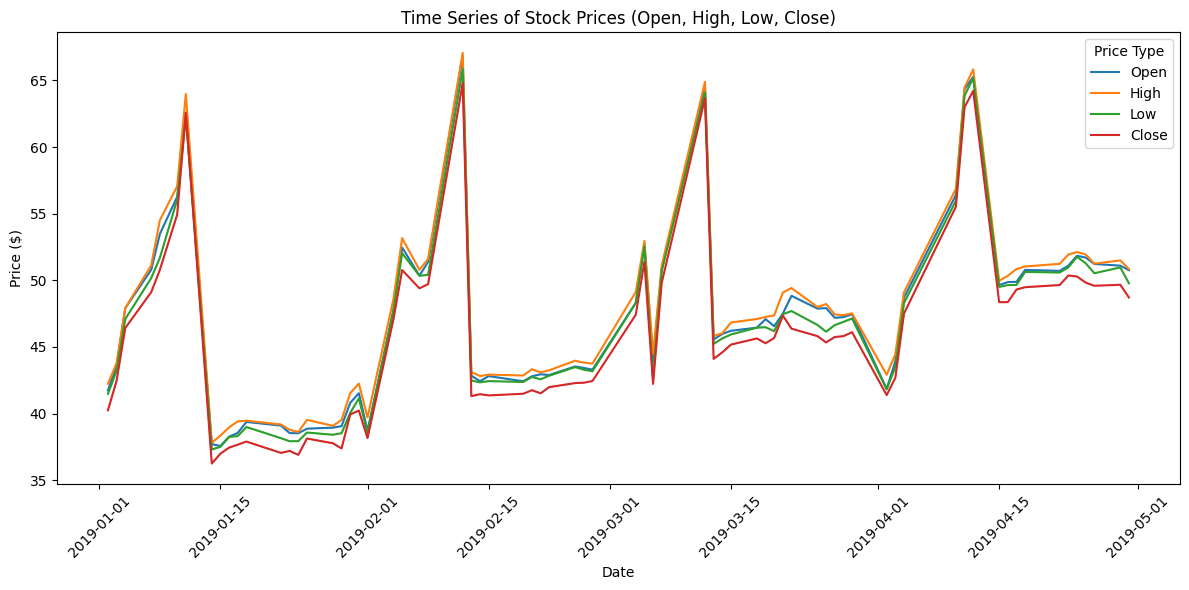

In [19]:
# Plot time series of Open, High, Low, and Close prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_stock_news[['Date', 'Open', 'High', 'Low', 'Close']].melt('Date', var_name='Price Type', value_name='Price'),
             x='Date', y='Price', hue='Price Type')
plt.title('Time Series of Stock Prices (Open, High, Low, Close)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* This looks like another interesting finding.
* It seems that **all prices surge on the first two weeks, and suddenly drop around day 12-14.** Then they remain stable the last two weeks of each month.
* Is there a particular news around these days?
* Also, it looks an upward trend on prices during these months.
* I'd suggest a further time-series analysis using Arima to capture this trend and some seasonality. More data should be required for that.

#### Date to Sentiment label time series analysis

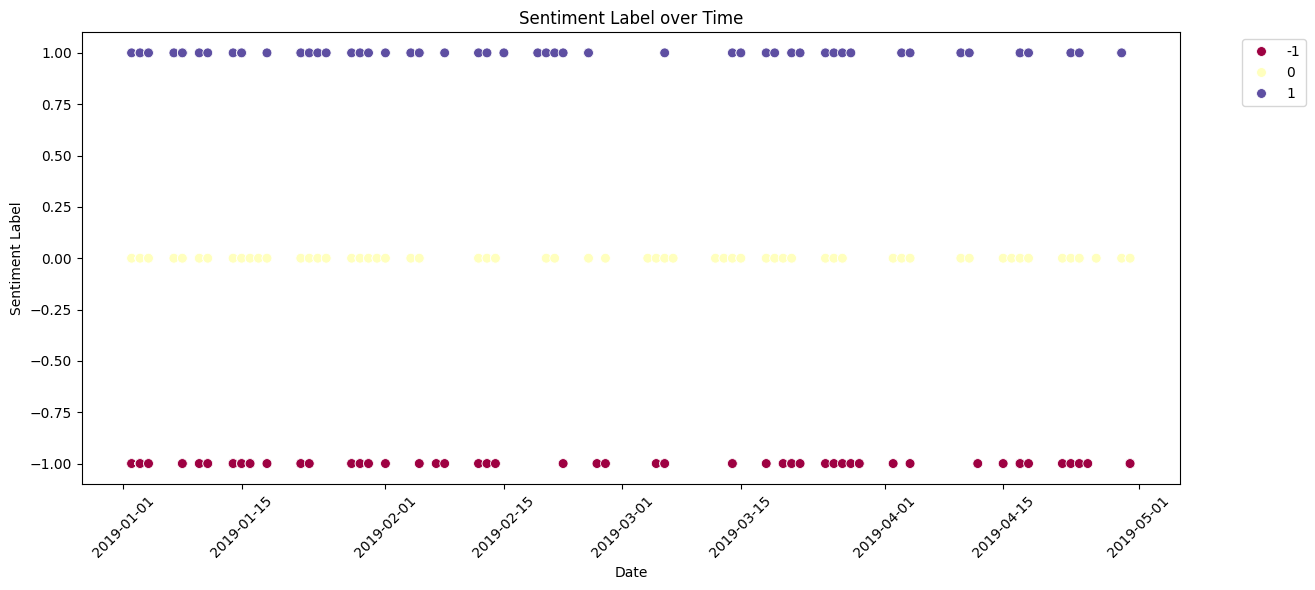

In [20]:
# Plot the distribution of 'Label' by 'Date' using a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_stock_news, x='Date', y='Label', hue='Label', palette='Spectral', s=50)
plt.title('Sentiment Label over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.show()

* We can not see a clear trend o relationship, because there are positive, neutral and negative sentiment labels during the entire date range.

Let's group labels by date, averaging their values.

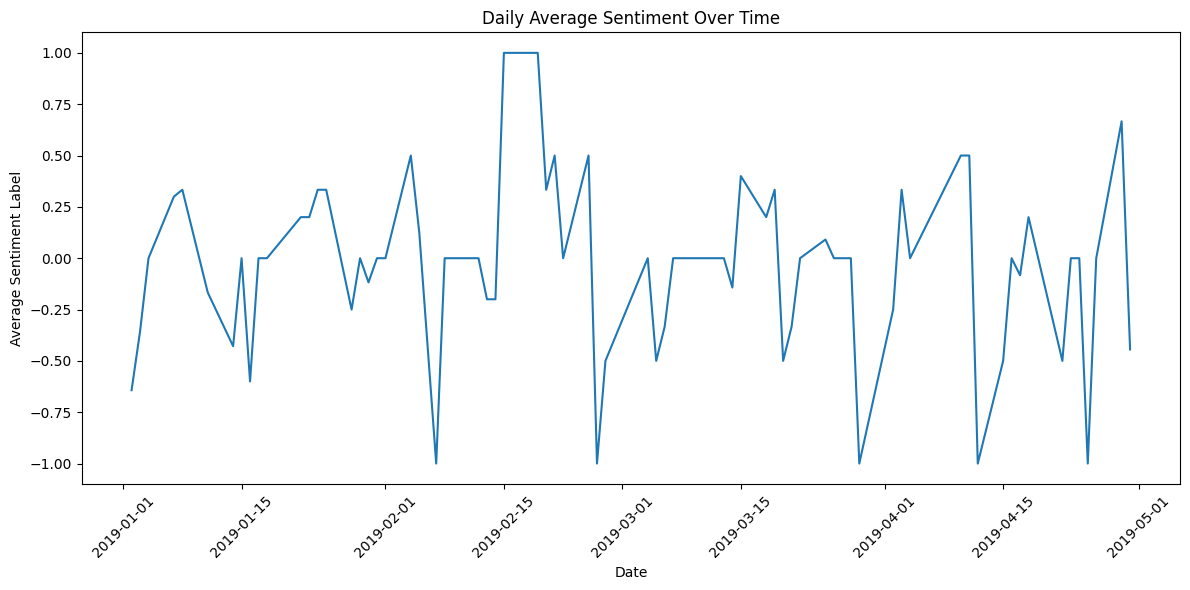

In [21]:
# Group by date and calculate the mean label
df_daily_sentiment = df_stock_news.groupby('Date')['Label'].mean().reset_index()

# Plot the daily average sentiment over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_daily_sentiment, x='Date', y='Label')
plt.title('Daily Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* In this chart, it's not clear any relationship either.

Let's aggregate at week level

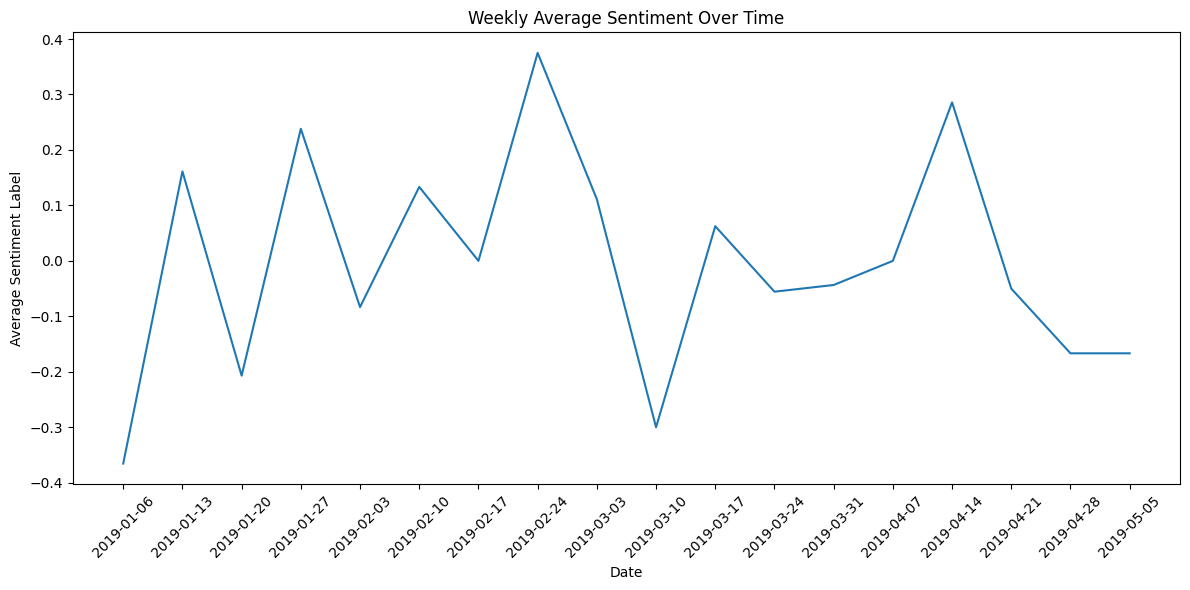

In [22]:
# Group by week and calculate the mean label, with the week starting on Monday
df_weekly_sentiment = df_stock_news.groupby(pd.Grouper(key='Date', freq='W'))['Label'].mean().reset_index()

# Convert Date to string for plotting on x-axis
df_weekly_sentiment['Date_str'] = df_weekly_sentiment['Date'].dt.strftime('%Y-%m-%d')

# Plot the weekly average sentiment over time as a bar plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_weekly_sentiment, x='Date_str', y='Label', palette='Spectral')
plt.title('Weekly Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Label')

# Set x-axis ticks to show all weekly dates
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Each data point represents the average label for the past seven days.
* Again, there is no clear trend or relationship at week level either.

Let's see if there is any correlation between Sentiment Label and the length of news...

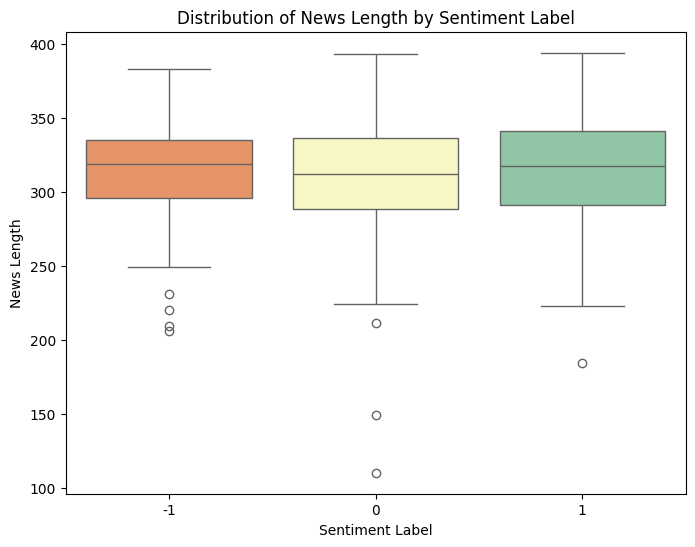

In [23]:
# Plot the distribution of 'News_Length' for each 'Label' value
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_stock_news, x='Label', y='News_Length', palette='Spectral')
plt.title('Distribution of News Length by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('News Length')
plt.show()

* No. Median news length and the interquartile range are similar across all three sentiment labels (-1, 0, and 1). This suggests that the length of the news article is not strongly correlated with the sentiment expressed in it.

So , the only relevant relationships were:
- Sentiment label to price: The median price value is higher when positive/neutral labeled news.
- Date to price: Upward trend on prices the first two weeks of month, and a sudden loss in prices.

Now, let's prepare data for sentiment analysis based on the news content!

## **Data Preprocessing**

### **Word Embeddings**

#### **Word2Vec**

In [24]:
# Create a copy of the dataset
data_word2vec=df_stock_news.copy()

In [25]:
# Preprocess news into tokens using simple_preprocess
data_word2vec['tokens'] = data_word2vec['News'].apply(lambda x: simple_preprocess(x))

In [26]:
# Train the word2vec model preprocesssed data
model_word2vec = Word2Vec(sentences=data_word2vec['tokens'], vector_size=300, window=5, min_count=1, workers=4,seed=my_seed)

In [27]:
# Define a function to get the average Word2Vec vector for text.
def get_avg_word_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [28]:
# Compute the embedding of each row
data_word2vec['embedded_vector'] = data_word2vec['tokens'].apply(lambda x: get_avg_word_vector(x, model_word2vec))

* Ok, I have the Word2Vec model

#### **Sentence Transformer**

In [29]:
# Create a copy of the dataset
data_sentf=df_stock_news.copy()

In [30]:
# Load the pre-trained SentenceTransformer model all-MiniLM-L6-v2.
model_sentf = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
# Create embeddings for News using the SentenceTransformer model.
def get_combined_embedding(news, model):
    # Create a combined string
    combined_text = f"{news}"
    # Generate embedding for the combined text
    embedding = model.encode(combined_text)
    return embedding

# Apply the function to create embeddings
data_sentf['embedded_vector'] = data_sentf.apply(
    lambda row: get_combined_embedding(row['News'], model_sentf), axis=1
)

* Ok, now I have the sentence transformer model !

## **Sentiment Analysis**

### **Model Evaluation Criterion**

##### **Sentiment Analysis strategy**

The following tasks are focused on improving the accuracy of the sentiment analysis models on unseen data (the test set) to enhance the prediction of sentiment labels based on the news content. I will explore different modeling approaches and fine-tuning techniques to achieve this goal.

Initially, I will consider oversampling training data in order to take care of the observed class imbalance; but in the last task, I will also consider creating classification models without using oversampling just to compare results.


---



Build Random Forest Models using different text embeddings
* Word2Vec
* Sentence Transformer

Build Neural Network Models using different text embeddings
* Word2Vec
* Sentence Transformer

Fine-tune Word2Vec embeddings
* Build Random Forest Model
* Build Neural Network Model

Fine-tune Sentence transformer embeddings
* Build Random Forest Model
* Build Neural Network Model

Fine-tune the classification analysis
* Grid Search Random Forest hyper-parameters
* Fine-tune the Neural network model
* Other ML Classifiers

Fine-tune the classification analysis without using oversampling train data
* ML Classifiers
* Neural network model

##### **Utility Functions**

In [32]:
def plot_confusion_matrix(title, actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title(title+'\nConfusion Matrix')

    # Display the plot
    plt.show()

In [33]:
def model_performance_classification_sklearn(model_name, actual_train, predicted_train, actual_test, predicted_test):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc_train = accuracy_score(actual_train,predicted_train)
    acc_test = accuracy_score(actual_test,predicted_test)

    # Compute Recall
    recall_train = recall_score(actual_train,predicted_train,average='weighted')
    recall_test = recall_score(actual_test,predicted_test,average='weighted')

    # Compute Precision
    precision_train = precision_score(actual_train,predicted_train,average='weighted')
    precision_test = precision_score(actual_test,predicted_test,average='weighted')

    # Compute F1-score
    f1_train = f1_score(actual_train,predicted_train,average='weighted')
    f1_test = f1_score(actual_test,predicted_test,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Model": model_name,
            "Accuracy_train": [acc_train],
            "Recall_train": [recall_train],
            "Precision_train": [precision_train],
            "F1_train": [f1_train],
            "Accuracy_test": [acc_test],
            "Recall_test": [recall_test],
            "Precision_test": [precision_test],
            "F1_test": [f1_test]
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

model_eval_results = pd.DataFrame(columns=['Model', 'Accuracy_train', 'Recall_train', 'Precision_train', 'F1_train', 'Accuracy_test', 'Recall_test', 'Precision_test', 'F1_test'])

### **Build Random Forest Models using different text embeddings**

##### **Word2Vec**

In [34]:
# Storing independent variable
X = data_word2vec['embedded_vector'].copy()

# Storing target variable
y = data_word2vec.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed (0,1,2)
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Building the model
rf_word2vec = RandomForestClassifier(random_state = my_seed, n_estimators=100, max_depth=3)

# Fitting on train data (oversampled data)
rf_word2vec.fit(X_train_res, y_train_res_shifted)

# Evaluate the model on original training data
y_train_pred = rf_word2vec.predict(X_train)

# Convert predictions back to original labels
y_train_pred = y_train_pred - 1

# Evaluate the model on testing data (original test data)
y_test_pred = rf_word2vec.predict(X_test)

# Convert predictions back to original labels
y_test_pred = y_test_pred - 1


# Store results
title = "RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3"
new_row = model_performance_classification_sklearn(title, y_train, y_train_pred, y_test, y_test_pred)
model_eval_results = pd.concat([model_eval_results, new_row], ignore_index=True)

# Show results
display(model_eval_results)

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676


#### **Sentence Transformer**

In [35]:
# Storing independent variable
X = data_sentf['embedded_vector'].copy()

# Storing target variable
y = data_sentf.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed (0,1,2)
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Building the model
rf_sentf = RandomForestClassifier(random_state = my_seed, n_estimators=100, max_depth=3)

# Fitting on train data
rf_sentf.fit(X_train_res, y_train_res_shifted)

# Evaluate the model on original training data
y_train_pred = rf_sentf.predict(X_train)

# Convert predictions back to original labels
y_train_pred = y_train_pred - 1

# Evaluate the model on testing data
y_test_pred = rf_sentf.predict(X_test)

# Convert predictions back to original labels
y_test_pred = y_test_pred - 1

# Store results
title = "RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3"
new_row = model_performance_classification_sklearn(title, y_train, y_train_pred, y_test, y_test_pred)
model_eval_results = pd.concat([model_eval_results, new_row], ignore_index=True)

# Show results
model_eval_results

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676
1,"RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.893994,0.893475,0.438095,0.438095,0.445359,0.440607


* Sentence transformer yields better performance than Word2Vec under the same Random Forest classifier
* Let's try the ANN...

### **Building Neural Network Models using different text embeddings**

##### **Word2Vec**

In [36]:
# Storing independent variable
X = data_word2vec['embedded_vector'].copy()

# Storing target variable
y = data_word2vec.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed.
# loss function 'sparse_categorical_crossentropy' requires y to be positive integers, so I'll add 1 to start values at 0
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Building the model

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Since labels are integers
    metrics=['f1_score']
)

num_epochs = 20
# Fitting the model
history = model.fit(
    X_train_res, y_train_res_shifted,
    #validation_data=(X_test, y_test_shifted),
    epochs=num_epochs,
    batch_size=32,
    verbose=0
    )

# Predict class probabilities on training data
y_train_pred_probs = model.predict(X_train)

# Convert probabilities to class labels and shift back to original labels
y_train_preds_shifted = tf.argmax(y_train_pred_probs, axis=1).numpy()
y_train_preds = y_train_preds_shifted - 1

# Predict class probabilities on test data
y_test_pred_probs = model.predict(X_test)

# Convert probabilities to class labels and shift back to original labels
y_test_preds_shifted = tf.argmax(y_test_pred_probs, axis=1).numpy()
y_test_preds = y_test_preds_shifted - 1

# Store results
title = "Neural Network Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=" + str(num_epochs) + ", test_size=.3"
new_row_nn = model_performance_classification_sklearn(title, y_train, y_train_preds, y_test, y_test_preds)
model_eval_results = pd.concat([model_eval_results, new_row_nn], ignore_index=True)

# Show results
model_eval_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676
1,"RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.893994,0.893475,0.438095,0.438095,0.445359,0.440607
2,"Neural Network Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582


##### **Sentence Transformer**

In [37]:
# Storing independent variable
X = data_sentf['embedded_vector'].copy()

# Storing target variable
y = data_sentf.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Building the model

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Since labels are integers
    metrics=['f1_score']
)

num_epochs = 20
# Fitting the model
history = model.fit(
    X_train_res, y_train_res_shifted,
    #validation_data=(X_test, y_test_shifted),
    epochs=num_epochs,
    batch_size=32,
    verbose=0
    )

# Predict class probabilities on training data
y_train_pred_probs = model.predict(X_train)

# Convert probabilities to class labels and shift back to original labels
y_train_preds_shifted = tf.argmax(y_train_pred_probs, axis=1).numpy()
y_train_preds = y_train_preds_shifted - 1

# Predict class probabilities on test data
y_test_pred_probs = model.predict(X_test)

# Convert probabilities to class labels and shift back to original labels
y_test_preds_shifted = tf.argmax(y_test_pred_probs, axis=1).numpy()
y_test_preds = y_test_preds_shifted - 1

# Store results
title = "Neural Network Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=" + str(num_epochs) + ", test_size=.3"
new_row_nn = model_performance_classification_sklearn(title, y_train, y_train_preds, y_test, y_test_preds)
model_eval_results = pd.concat([model_eval_results, new_row_nn], ignore_index=True)

# Show results
model_eval_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676
1,"RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.893994,0.893475,0.438095,0.438095,0.445359,0.440607
2,"Neural Network Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
3,"Neural Network Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.991803,0.991803,0.992034,0.991827,0.457143,0.457143,0.467444,0.459206


* I see overfitting on train data in the last NN model, but underfitting on test data.
* Accuracy results on test data are not great to predict Sentiment Label from News.

Let's start doing fine-tunning...

### **Fine-tune Word2Vec**

In [38]:
# Continue training the existing word2vec model with the new data
model_word2vec.build_vocab(data_word2vec['tokens'], update=True)
model_word2vec.train(data_word2vec['tokens'], total_examples=model_word2vec.corpus_count, epochs=model_word2vec.epochs)

(64888, 79985)

In [39]:
# Compute the embedding of each row
data_word2vec['embedded_vector'] = data_word2vec['tokens'].apply(lambda x: get_avg_word_vector(x, model_word2vec))

##### **Build Random Forest Model using fine-tuned Word2Vec embeddings**

In [40]:
# Storing independent variable
X = data_word2vec['embedded_vector'].copy()

# Storing target variable
y = data_word2vec.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed (0,1,2)
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Building the model
rf_word2vec = RandomForestClassifier(random_state = my_seed, n_estimators=100, max_depth=3)

# Fitting on train data
rf_word2vec.fit(X_train_res, y_train_res_shifted)

# Evaluate the model on training data
y_train_pred = rf_word2vec.predict(X_train)

# Convert predictions back to original labels
y_train_pred = y_train_pred - 1

# Evaluate the model on testing data
y_test_pred = rf_word2vec.predict(X_test)

# Convert predictions back to original labels
y_test_pred = y_test_pred - 1

# Store results
title = "RandomForest + fine-tuned Word2Vec, n_estimators=100, max_depth=3, test_size=.3"
new_row = model_performance_classification_sklearn(title, y_train, y_train_pred, y_test, y_test_pred)
model_eval_results = pd.concat([model_eval_results, new_row], ignore_index=True)

# Show results
model_eval_results

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676
1,"RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.893994,0.893475,0.438095,0.438095,0.445359,0.440607
2,"Neural Network Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
3,"Neural Network Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.991803,0.991803,0.992034,0.991827,0.457143,0.457143,0.467444,0.459206
4,"RandomForest + fine-tuned Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.766393,0.766393,0.774825,0.768372,0.352381,0.352381,0.401465,0.350855


##### **Build Neural Network Model using fine-tuned Word2Vec embeddings**

In [41]:
# Storing independent variable
X = data_word2vec['embedded_vector'].copy()

# Storing target variable
y = data_word2vec.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed. This is necessary for the loss function.
# loss function 'sparse_categorical_crossentropy' requires y to be positive integers, so I'll add 1 to start values at 0
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Building the model

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Since labels are integers
    metrics=['f1_score']
)

num_epochs = 20
# Fitting the model
history = model.fit(
    X_train_res, y_train_res_shifted,
    #validation_data=(X_test, y_test_shifted),
    epochs=num_epochs,
    batch_size=32,
    verbose=0
    )

# Predict class probabilities on training data
y_train_pred_probs = model.predict(X_train)

# Convert probabilities to class labels and shift back to original labels
y_train_preds_shifted = tf.argmax(y_train_pred_probs, axis=1).numpy()
y_train_preds = y_train_preds_shifted - 1

# Predict class probabilities on test data
y_test_pred_probs = model.predict(X_test)

# Convert probabilities to class labels and shift back to original labels
y_test_preds_shifted = tf.argmax(y_test_pred_probs, axis=1).numpy()
y_test_preds = y_test_preds_shifted - 1

# Store results
title = "Neural Network fine-tuned Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=" + str(num_epochs) + ", test_size=.3"
new_row_nn = model_performance_classification_sklearn(title, y_train, y_train_preds, y_test, y_test_preds)
model_eval_results = pd.concat([model_eval_results, new_row_nn], ignore_index=True)

# Show results
model_eval_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676
1,"RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.893994,0.893475,0.438095,0.438095,0.445359,0.440607
2,"Neural Network Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
3,"Neural Network Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.991803,0.991803,0.992034,0.991827,0.457143,0.457143,0.467444,0.459206
4,"RandomForest + fine-tuned Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.766393,0.766393,0.774825,0.768372,0.352381,0.352381,0.401465,0.350855
5,"Neural Network fine-tuned Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582


* We still have low accuracy values on test data using Word2Vec

Let's fine-tune sentence transformer embeddings

### **Fine-tune Sentence Transformer**

In order to fine-tune the embeddings, I need to prepare text sentences and their coresponding label.
I will keep using all-MiniLM-L6-v2 model, and will use a loss function designed to receive a single sentence (as opposed to paired-sentences) and a label.
I need to create an account at Weights and Biases (https://wandb.ai/) to get an authentication token. This is necessary to compile the new sentence model of embeddings.

##### Prepare for fine-tunning

In [42]:
data_ft = data_sentf.copy()

train_examples = []
for index, row in data_ft.iterrows():
    row_news = row['News']
    row_label = row['Label']
    train_examples.append(InputExample(texts=[row_news], label=row_label))

In [43]:
# Load the pre-trained SentenceTransformer model all-MiniLM-L6-v2.
model_sentf_ft = SentenceTransformer('all-MiniLM-L6-v2')

##### Define the training process

In [44]:
train_dataloader = DataLoader(train_examples, batch_size=16, shuffle=True)

loss_fct = losses.BatchAllTripletLoss(model_sentf_ft)

#loss_fct = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=len(data['Sentiment_Encoded'].unique()))

num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.25) # 25% of train data

##### Fine-tune the model

In [45]:
# Fine-tune the model
model_sentf_ft.fit(train_objectives=[(train_dataloader, loss_fct)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path='./output_model_all-MiniLM-L6-v2',
          show_progress_bar=True)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jose-quinonez (jose-quinonez-lopez) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


##### Generate new embeddings with the fine-tuned model

In [46]:
# Apply the function to create embeddings and store them in the new dataframe
data_ft['embedded_vector'] = data_ft.apply(
    lambda row: get_combined_embedding(row['News'], model_sentf_ft), axis=1
)

##### **Build Random Forest Model using fine-tuned sentence transformer embeddings**

In [47]:
# Storing independent variable
X = data_ft['embedded_vector'].copy()

# Storing target variable
y = data_ft.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed (0,1,2)
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Building the model
rf_sentf = RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = my_seed)

# Fitting on train data
rf_sentf.fit(X_train_res, y_train_res_shifted)

# Evaluate the model on training data
y_train_pred = rf_sentf.predict(X_train)

# Convert predictions back to original labels
y_train_pred = y_train_pred - 1

# Evaluate the model on testing data
y_test_pred = rf_sentf.predict(X_test)

# Convert predictions back to original labels
y_test_pred = y_test_pred - 1

# Store results
title = "RandomForest + fine-tuned Sentence Transformer  n_estimators=100, max_depth=3, test_size=.3"
new_row_rf = model_performance_classification_sklearn(title, y_train, y_train_pred, y_test, y_test_pred)
model_eval_results = pd.concat([model_eval_results, new_row_rf], ignore_index=True)

# Show results
model_eval_results

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676
1,"RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.893994,0.893475,0.438095,0.438095,0.445359,0.440607
2,"Neural Network Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
3,"Neural Network Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.991803,0.991803,0.992034,0.991827,0.457143,0.457143,0.467444,0.459206
4,"RandomForest + fine-tuned Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.766393,0.766393,0.774825,0.768372,0.352381,0.352381,0.401465,0.350855
5,"Neural Network fine-tuned Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
6,"RandomForest + fine-tuned Sentence Transformer n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.895407,0.893301,0.485714,0.485714,0.498413,0.488866


* Some improvement using the fine-tuned sentence transformer!
* Let's see the ANN...

##### **Build Neural Network Model using fine-tuned sentence transformer embeddings**

In [48]:
# Storing independent variable
X = data_ft['embedded_vector'].copy()

# Storing target variable
y = data_ft.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Building the model

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Since labels are integers
    metrics=['f1_score']
)

num_epochs = 20
# Fitting the model
history = model.fit(
    X_train_res, y_train_res_shifted,
    #validation_data=(X_test, y_test_shifted),
    epochs=num_epochs,
    batch_size=32,
    verbose=0
    )

# Predict class probabilities on training data
y_train_pred_probs = model.predict(X_train)

# Convert probabilities to class labels and shift back to original labels
y_train_preds_shifted = tf.argmax(y_train_pred_probs, axis=1).numpy()
y_train_preds = y_train_preds_shifted - 1

# Predict class probabilities on test data
y_test_pred_probs = model.predict(X_test)

# Convert probabilities to class labels and shift back to original labels
y_test_preds_shifted = tf.argmax(y_test_pred_probs, axis=1).numpy()
y_test_preds = y_test_preds_shifted - 1

# Store results
title = "Neural Network fine-tuned Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=" + str(num_epochs) + ", test_size=.3"
new_row_nn = model_performance_classification_sklearn(title, y_train, y_train_preds, y_test, y_test_preds)
model_eval_results = pd.concat([model_eval_results, new_row_nn], ignore_index=True)

# Show results
model_eval_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676
1,"RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.893994,0.893475,0.438095,0.438095,0.445359,0.440607
2,"Neural Network Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
3,"Neural Network Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.991803,0.991803,0.992034,0.991827,0.457143,0.457143,0.467444,0.459206
4,"RandomForest + fine-tuned Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.766393,0.766393,0.774825,0.768372,0.352381,0.352381,0.401465,0.350855
5,"Neural Network fine-tuned Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
6,"RandomForest + fine-tuned Sentence Transformer n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.895407,0.893301,0.485714,0.485714,0.498413,0.488866
7,"Neural Network fine-tuned Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",1.000000,1.000000,1.000000,1.000000,0.485714,0.485714,0.492063,0.488191


* NN is still overfitting on train data for sentence transformer. I'll have to simplify the architecture.
* The main point is that metrics on test data are still low.

Let's fine-tune the models...

### **Fine-tune the classification analysis**

##### **Grid Search Random Forest hyper-parameters**

In [49]:
# Storing independent variable
X = data_ft['embedded_vector'].copy()

# Storing target variable
y = data_ft.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed (0,1,2)
y_shifted = y + 1

# Split data into training and testing set FIRST
X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = 0.3, random_state = my_seed, stratify=y_shifted)

# Keep original labels for evaluation
y_train = y_train_shifted - 1
y_test = y_test_shifted - 1

# Instantiate SMOTE
smote = SMOTE(random_state=my_seed)

# Apply SMOTE only to the training data
X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=my_seed)

# Define a parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data with fine-tuned embeddings
grid_search.fit(X_train_res, y_train_res_shifted)

# Print the best hyperparameters found by Grid Search
print("Best hyperparameters found by Grid Search:")
print(grid_search.best_params_)

# Get the best model from the Grid Search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on original training data
y_train_pred = best_rf_model.predict(X_train)

# Convert predictions back to original labels
y_train_pred = y_train_pred - 1

# Evaluate the best model on test data
y_test_pred = best_rf_model.predict(X_test)

# Convert predictions back to original labels
y_test_pred = y_test_pred - 1

# Store results
title = "RandomForest GridSearch + fine-tuned Sentence Transformer, " + str(grid_search.best_params_)
new_row_rf = model_performance_classification_sklearn(title, y_train, y_train_pred, y_test, y_test_pred)
model_eval_results = pd.concat([model_eval_results, new_row_rf], ignore_index=True)

# Show results
model_eval_results

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyperparameters found by Grid Search:
{'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
0,"RandomForest + Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.762295,0.762295,0.782629,0.765242,0.409524,0.409524,0.447174,0.413676
1,"RandomForest + Sentence Transformer, n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.893994,0.893475,0.438095,0.438095,0.445359,0.440607
2,"Neural Network Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
3,"Neural Network Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.991803,0.991803,0.992034,0.991827,0.457143,0.457143,0.467444,0.459206
4,"RandomForest + fine-tuned Word2Vec, n_estimators=100, max_depth=3, test_size=.3",0.766393,0.766393,0.774825,0.768372,0.352381,0.352381,0.401465,0.350855
5,"Neural Network fine-tuned Word2Vec batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
6,"RandomForest + fine-tuned Sentence Transformer n_estimators=100, max_depth=3, test_size=.3",0.893443,0.893443,0.895407,0.893301,0.485714,0.485714,0.498413,0.488866
7,"Neural Network fine-tuned Sentence Transformer batch_size=32, Optimizer=adam, 2 hidden layers (128,64), drop-out=.3, Activation=relu, epochs=20, test_size=.3",1.000000,1.000000,1.000000,1.000000,0.485714,0.485714,0.492063,0.488191
8,"RandomForest GridSearch + fine-tuned Sentence Transformer, {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",1.000000,1.000000,1.000000,1.000000,0.495238,0.495238,0.504553,0.487522


* Now the best classifier from grid-search RanfomForest also overfitted on training data.
* Let's fine-tune the ANN...

##### **Fine-tune the Neural network model**

In [50]:
# Storing independent variable
X = data_ft['embedded_vector'].copy()

# Storing target variable
y = data_ft.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed
y_shifted = y + 1

best_acc_nn = np.NINF
best_model_nn = None
best_title_nn = None
best_y_test_preds = None
best_y_test = None

# Try several test_size values
for test_size in [0.2, 0.3]:

  # Split data into training and testing set FIRST
  X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = test_size, random_state = my_seed, stratify=y_shifted)

  # Keep original labels for evaluation
  y_train = y_train_shifted - 1
  y_test = y_test_shifted - 1

  # Instantiate SMOTE
  smote = SMOTE(random_state=my_seed)

  # Apply SMOTE only to the training data
  X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)

  # Building the model

  for num_neurons in [32, 64]:
    for activation in ['relu', 'selu']:
      for batch_size in [16, 32]:
        for num_epochs in [20, 40]:
          for optimizer in ['adam', 'sgd']:
            print("Model: test_size " + str(test_size) + ", neurons  " + str(num_neurons) + ", activation " + activation +
                  ", batch_size " + str(batch_size) + ", num epochs " + str(num_epochs) + ", optimizer" + optimizer)

            # Clear previous sessions
            tf.keras.backend.clear_session()
            gc.collect()

            # Model definition with One hidden layer
            model = Sequential()
            model.add(Dense(num_neurons, activation=activation, input_shape=(X_train_res.shape[1],)))
            model.add(Dense(3, activation='softmax'))  # 3 output classes

            # Compile
            model.compile(
                optimizer=optimizer,
                loss='sparse_categorical_crossentropy',  # Since labels are integers
                metrics=['f1_score']
            )

            # Fitting the model
            history = model.fit(
                X_train_res, y_train_res_shifted,
                #validation_data=(X_test, y_test_shifted),
                epochs=num_epochs,
                batch_size=batch_size,
                verbose=0
                )

            # Predict class probabilities on training data
            y_train_pred_probs = model.predict(X_train)

            # Convert probabilities to class labels and shift back to original labels
            y_train_preds_shifted = tf.argmax(y_train_pred_probs, axis=1).numpy()
            y_train_preds = y_train_preds_shifted - 1

            # Predict class probabilities on test data
            y_test_pred_probs = model.predict(X_test)

            # Convert probabilities to class labels and shift back to original labels
            y_test_preds_shifted = tf.argmax(y_test_pred_probs, axis=1).numpy()
            y_test_preds = y_test_preds_shifted - 1

            # Store results
            title = "Neural Network fine-tuned Sentence Transformer: batch_size=" + str(batch_size) + ", Optimizer=" + optimizer + \
            ", 1 hidden layer (" + str(num_neurons) + "), No drop-out, Activation=" + activation + ", epochs=" + str(num_epochs) + ", test_size=" + str(test_size)
            new_row_nn = model_performance_classification_sklearn(title, y_train, y_train_preds, y_test, y_test_preds)
            model_eval_results = pd.concat([model_eval_results, new_row_nn], ignore_index=True)

            if new_row_nn['Accuracy_test'].iloc[0] > best_acc_nn:
              best_acc_nn = new_row_nn['Accuracy_test'].iloc[0]
              best_model_nn = model
              best_title_nn = title
              best_y_test_preds = y_test_preds
              best_y_test = y_test

# Show results
model_eval_results.tail(64)

Model: test_size 0.2, neurons  32, activation relu, batch_size 16, num epochs 20, optimizeradam
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 16, num epochs 20, optimizersgd
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 16, num epochs 40, optimizeradam
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 16, num epochs 40, optimizersgd
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 32, num epochs 20, optimizeradam
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 32, num epochs 20, optimizersgd
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
9,"Neural Network fine-tuned Sentence Transformer: batch_size=16, Optimizer=adam, 1 hidden layer (32), No drop-out, Activation=relu, epochs=20, test_size=0.2",0.856631,0.856631,0.858319,0.856723,0.457143,0.457143,0.469341,0.459839
10,"Neural Network fine-tuned Sentence Transformer: batch_size=16, Optimizer=sgd, 1 hidden layer (32), No drop-out, Activation=relu, epochs=20, test_size=0.2",0.444444,0.444444,0.511326,0.434913,0.400000,0.400000,0.448918,0.380112
11,"Neural Network fine-tuned Sentence Transformer: batch_size=16, Optimizer=adam, 1 hidden layer (32), No drop-out, Activation=relu, epochs=40, test_size=0.2",0.982079,0.982079,0.982081,0.982060,0.471429,0.471429,0.478063,0.473348
12,"Neural Network fine-tuned Sentence Transformer: batch_size=16, Optimizer=sgd, 1 hidden layer (32), No drop-out, Activation=relu, epochs=40, test_size=0.2",0.548387,0.548387,0.593952,0.535429,0.471429,0.471429,0.491685,0.458366
13,"Neural Network fine-tuned Sentence Transformer: batch_size=32, Optimizer=adam, 1 hidden layer (32), No drop-out, Activation=relu, epochs=20, test_size=0.2",0.792115,0.792115,0.796726,0.792380,0.471429,0.471429,0.481331,0.472287
...,...,...,...,...,...,...,...,...,...
68,"Neural Network fine-tuned Sentence Transformer: batch_size=16, Optimizer=sgd, 1 hidden layer (64), No drop-out, Activation=selu, epochs=40, test_size=0.3",0.672131,0.672131,0.687611,0.670993,0.428571,0.428571,0.442979,0.427937
69,"Neural Network fine-tuned Sentence Transformer: batch_size=32, Optimizer=adam, 1 hidden layer (64), No drop-out, Activation=selu, epochs=20, test_size=0.3",0.897541,0.897541,0.901132,0.897807,0.485714,0.485714,0.493213,0.487619
70,"Neural Network fine-tuned Sentence Transformer: batch_size=32, Optimizer=sgd, 1 hidden layer (64), No drop-out, Activation=selu, epochs=20, test_size=0.3",0.545082,0.545082,0.551789,0.543976,0.466667,0.466667,0.487030,0.471328
71,"Neural Network fine-tuned Sentence Transformer: batch_size=32, Optimizer=adam, 1 hidden layer (64), No drop-out, Activation=selu, epochs=40, test_size=0.3",0.987705,0.987705,0.988217,0.987757,0.485714,0.485714,0.490165,0.487486


In [51]:
# Best Neural Network model
model_eval_results[model_eval_results['Model'] == best_title_nn]

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
50,"Neural Network fine-tuned Sentence Transformer: batch_size=16, Optimizer=sgd, 1 hidden layer (32), No drop-out, Activation=selu, epochs=20, test_size=0.3",0.590164,0.590164,0.600322,0.592107,0.514286,0.514286,0.524198,0.518471


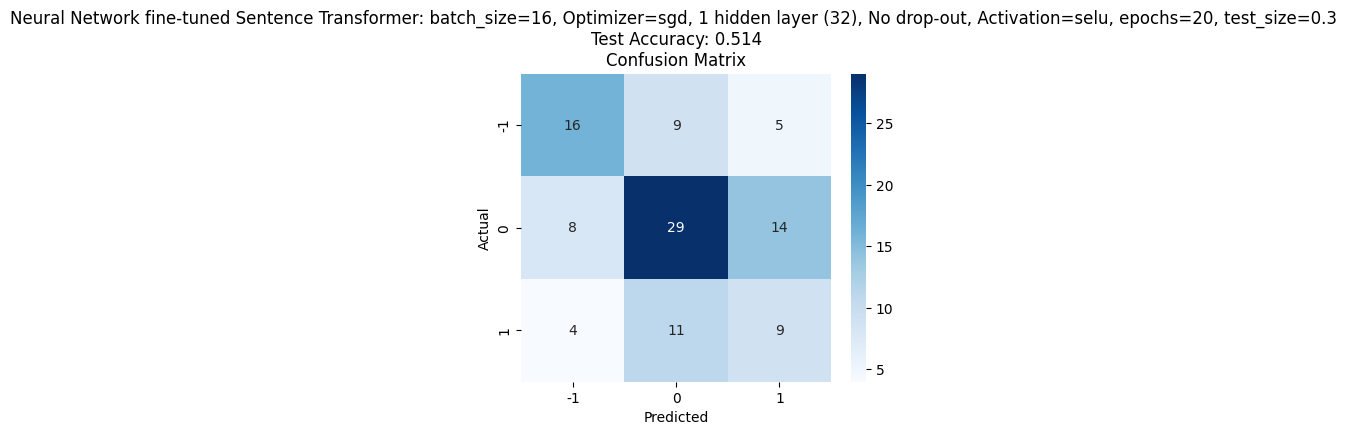

In [52]:
# Show Confusion matrix
plot_confusion_matrix(f"{best_title_nn} \nTest Accuracy: {best_acc_nn:.3f}", best_y_test, best_y_test_preds)

* Ok, that was exhaustive! So we have .514 accuracy on test data and not much overfitting on train data

Now I want to try another non-NN ML classifiers

##### **Other ML Classifiers**

In [53]:
# Trying with some Non-NN classifiers
cls_dict = {'Random Forest GridSearch': best_rf_model,
            'Random Forest': RandomForestClassifier(random_state=my_seed),
            'Gradient Boosting': GradientBoostingClassifier(random_state = my_seed),
            'XGBoost': xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=my_seed),
            'Gaussian Naive Bayes': GaussianNB(),
            'Support Vector Machine': SVC(probability=True, random_state=my_seed),
            'K-Nearest Neighbors': KNeighborsClassifier()}

# Storing independent variable
X = data_ft['embedded_vector'].copy()

# Storing target variable and shifting labels to be 0-indexed for all classifiers
y = data_ft.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed (0,1,2)
y_shifted = y + 1

best_acc_not_nn = np.NINF
best_model_not_nn = None
best_title_not_nn = None
best_y_test = None
best_y_test_pred = None

# Try several test size options
for test_size in [0.2, 0.3, 0.4]:

  # Split data into training and testing set FIRST
  X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = test_size, random_state = my_seed, stratify=y_shifted)

  # Keep original labels for evaluation
  y_train = y_train_shifted - 1
  y_test = y_test_shifted - 1

  # Instantiate SMOTE
  smote = SMOTE(random_state=my_seed)

  # Apply SMOTE only to the training data
  X_train_res, y_train_res_shifted = smote.fit_resample(X_train, y_train_shifted)


  for cls_name, cls in cls_dict.items():
    # print iteration
    title = cls_name + "+ fine-tuned Sentence Transformer, test_size=" + str(test_size)
    print(title)

    # Building the model
    model_sentf = cls

    # Fitting on train data
    cls.fit(X_train_res, y_train_res_shifted)

    # Evaluate the model on training data
    y_train_pred = cls.predict(X_train)

    # Convert predictions back to original labels
    y_train_pred = y_train_pred - 1

    # Evaluate the model on testing data
    y_test_pred = cls.predict(X_test)

    # Convert predictions back to original labels
    y_test_pred = y_test_pred - 1

    # Store results
    new_row = model_performance_classification_sklearn(title, y_train, y_train_pred, y_test, y_test_pred)
    model_eval_results = pd.concat([model_eval_results, new_row], ignore_index=True)

    if new_row['Accuracy_test'].iloc[0] > best_acc_not_nn:
      best_acc_not_nn = new_row['Accuracy_test'].iloc[0]
      best_model_not_nn = cls
      best_title_not_nn = title
      best_y_test = y_test
      best_y_test_pred = y_test_pred

# Show results
model_eval_results.tail(21)

Random Forest GridSearch+ fine-tuned Sentence Transformer, test_size=0.2
Random Forest+ fine-tuned Sentence Transformer, test_size=0.2
Gradient Boosting+ fine-tuned Sentence Transformer, test_size=0.2
XGBoost+ fine-tuned Sentence Transformer, test_size=0.2
Gaussian Naive Bayes+ fine-tuned Sentence Transformer, test_size=0.2
Support Vector Machine+ fine-tuned Sentence Transformer, test_size=0.2
K-Nearest Neighbors+ fine-tuned Sentence Transformer, test_size=0.2
Random Forest GridSearch+ fine-tuned Sentence Transformer, test_size=0.3
Random Forest+ fine-tuned Sentence Transformer, test_size=0.3
Gradient Boosting+ fine-tuned Sentence Transformer, test_size=0.3
XGBoost+ fine-tuned Sentence Transformer, test_size=0.3
Gaussian Naive Bayes+ fine-tuned Sentence Transformer, test_size=0.3
Support Vector Machine+ fine-tuned Sentence Transformer, test_size=0.3
K-Nearest Neighbors+ fine-tuned Sentence Transformer, test_size=0.3
Random Forest GridSearch+ fine-tuned Sentence Transformer, test_size=0

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
73,"Random Forest GridSearch+ fine-tuned Sentence Transformer, test_size=0.2",1.000000,1.000000,1.000000,1.000000,0.557143,0.557143,0.568914,0.550684
74,"Random Forest+ fine-tuned Sentence Transformer, test_size=0.2",1.000000,1.000000,1.000000,1.000000,0.428571,0.428571,0.433878,0.426827
75,"Gradient Boosting+ fine-tuned Sentence Transformer, test_size=0.2",1.000000,1.000000,1.000000,1.000000,0.514286,0.514286,0.514286,0.512098
76,"XGBoost+ fine-tuned Sentence Transformer, test_size=0.2",1.000000,1.000000,1.000000,1.000000,0.528571,0.528571,0.539500,0.532063
77,"Gaussian Naive Bayes+ fine-tuned Sentence Transformer, test_size=0.2",0.659498,0.659498,0.660961,0.659080,0.514286,0.514286,0.501866,0.499248
78,"Support Vector Machine+ fine-tuned Sentence Transformer, test_size=0.2",0.942652,0.942652,0.942809,0.942457,0.542857,0.542857,0.566440,0.534218
79,"K-Nearest Neighbors+ fine-tuned Sentence Transformer, test_size=0.2",0.612903,0.612903,0.713357,0.582749,0.428571,0.428571,0.508894,0.398646
80,"Random Forest GridSearch+ fine-tuned Sentence Transformer, test_size=0.3",1.000000,1.000000,1.000000,1.000000,0.495238,0.495238,0.504553,0.487522
81,"Random Forest+ fine-tuned Sentence Transformer, test_size=0.3",1.000000,1.000000,1.000000,1.000000,0.495238,0.495238,0.486906,0.486905
82,"Gradient Boosting+ fine-tuned Sentence Transformer, test_size=0.3",1.000000,1.000000,1.000000,1.000000,0.447619,0.447619,0.451933,0.448633


In [54]:
# Best Non Neural Network model
model_eval_results[model_eval_results['Model'] == best_title_not_nn]

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
73,"Random Forest GridSearch+ fine-tuned Sentence Transformer, test_size=0.2",1.0,1.0,1.0,1.0,0.557143,0.557143,0.568914,0.550684


* Still overfitting on train data, but underfitting on test data.

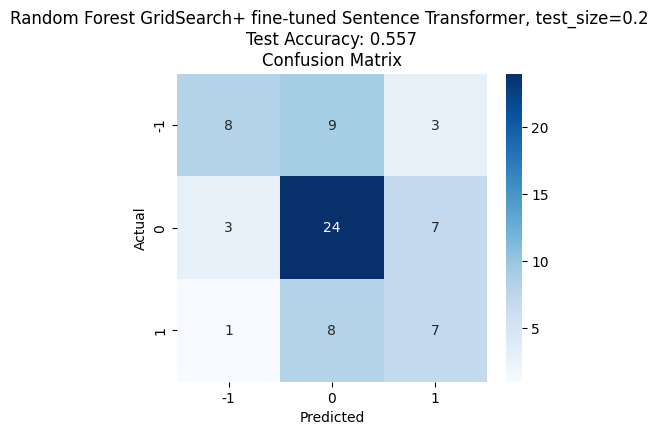

In [55]:
# Evaluate the best model on test data
plot_confusion_matrix(f"{best_title_not_nn} \nTest Accuracy: {best_acc_not_nn:.3f}", best_y_test, best_y_test_pred)

* The correct predictions on the diagonal sum 39 out of 70 test observations.

### **Fine-tune the classification anaysis NOT using oversampling on train data**

##### **ML Clasiffiers**

In [56]:
# Trying with some Non-NN classifiers
cls_dict = {'Random Forest GridSearch': best_rf_model,
            'Random Forest': RandomForestClassifier(random_state=my_seed),
            'Gradient Boosting': GradientBoostingClassifier(random_state = my_seed),
            'XGBoost': xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=my_seed),
            'Gaussian Naive Bayes': GaussianNB(),
            'Support Vector Machine': SVC(probability=True, random_state=my_seed),
            'K-Nearest Neighbors': KNeighborsClassifier()}

# Storing independent variable
X = data_ft['embedded_vector'].copy()

# Storing target variable and shifting labels to be 0-indexed for all classifiers
y = data_ft.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed (0,1,2)
y_shifted = y + 1

best_acc_not_nn = np.NINF
best_model_not_nn = None
best_title_not_nn = None
best_y_test = None
best_y_test_pred = None

# Try several test size options
for test_size in [0.2, 0.3, 0.4]:

  # Split data into training and testing set FIRST
  X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = test_size, random_state = my_seed, stratify=y_shifted)

  # Keep original labels for evaluation
  y_train = y_train_shifted - 1
  y_test = y_test_shifted - 1

  for cls_name, cls in cls_dict.items():
    # print iteration
    title = cls_name + "+ fine-tuned Sentence Transformer (no oversampling), test_size=" + str(test_size)
    print(title)

    # Building the model
    model_sentf = cls

    # Fitting on train data
    cls.fit(X_train, y_train_shifted)

    # Evaluate the model on training data
    y_train_pred = cls.predict(X_train)

    # Convert predictions back to original labels
    y_train_pred = y_train_pred - 1

    # Evaluate the model on testing data
    y_test_pred = cls.predict(X_test)

    # Convert predictions back to original labels
    y_test_pred = y_test_pred - 1

    # Store results
    new_row = model_performance_classification_sklearn(title, y_train, y_train_pred, y_test, y_test_pred)
    model_eval_results = pd.concat([model_eval_results, new_row], ignore_index=True)

    if new_row['Accuracy_test'].iloc[0] > best_acc_not_nn:
      best_acc_not_nn = new_row['Accuracy_test'].iloc[0]
      best_model_not_nn = cls
      best_title_not_nn = title
      best_y_test = y_test
      best_y_test_pred = y_test_pred

# Show results
model_eval_results.tail(21)

Random Forest GridSearch+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2
Random Forest+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2
Gradient Boosting+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2
XGBoost+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2
Gaussian Naive Bayes+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2
Support Vector Machine+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2
K-Nearest Neighbors+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2
Random Forest GridSearch+ fine-tuned Sentence Transformer (no oversampling), test_size=0.3
Random Forest+ fine-tuned Sentence Transformer (no oversampling), test_size=0.3
Gradient Boosting+ fine-tuned Sentence Transformer (no oversampling), test_size=0.3
XGBoost+ fine-tuned Sentence Transformer (no oversampling), test_size=0.3
Gaussian Naive Bayes+ fine-tuned Sentence Transformer (no oversampling), test_si

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
94,"Random Forest GridSearch+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2",1.000000,1.000000,1.000000,1.000000,0.571429,0.571429,0.679765,0.508996
95,"Random Forest+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2",1.000000,1.000000,1.000000,1.000000,0.542857,0.542857,0.560866,0.497097
96,"Gradient Boosting+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2",1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.472955,0.473190
97,"XGBoost+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2",1.000000,1.000000,1.000000,1.000000,0.542857,0.542857,0.552915,0.531815
98,"Gaussian Naive Bayes+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2",0.706093,0.706093,0.715827,0.707173,0.500000,0.500000,0.504127,0.496785
99,"Support Vector Machine+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2",0.896057,0.896057,0.906349,0.894988,0.528571,0.528571,0.581376,0.489311
100,"K-Nearest Neighbors+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2",0.641577,0.641577,0.658744,0.635471,0.557143,0.557143,0.546375,0.543675
101,"Random Forest GridSearch+ fine-tuned Sentence Transformer (no oversampling), test_size=0.3",1.000000,1.000000,1.000000,1.000000,0.542857,0.542857,0.563201,0.495207
102,"Random Forest+ fine-tuned Sentence Transformer (no oversampling), test_size=0.3",1.000000,1.000000,1.000000,1.000000,0.523810,0.523810,0.512542,0.474128
103,"Gradient Boosting+ fine-tuned Sentence Transformer (no oversampling), test_size=0.3",1.000000,1.000000,1.000000,1.000000,0.457143,0.457143,0.448644,0.448639


In [57]:
# Best Non Neural Network model
model_eval_results[model_eval_results['Model'] == best_title_not_nn]

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
94,"Random Forest GridSearch+ fine-tuned Sentence Transformer (no oversampling), test_size=0.2",1.0,1.0,1.0,1.0,0.571429,0.571429,0.679765,0.508996


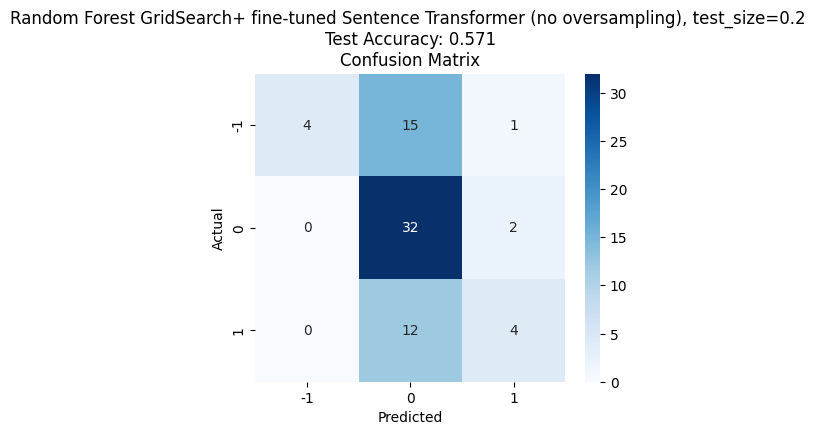

In [58]:
# Show Confusion matrix
plot_confusion_matrix(f"{best_title_not_nn} \nTest Accuracy: {best_acc_not_nn:.3f}", best_y_test, best_y_test_pred)

* The correct predictions on the diagonal sum 40, out of 70 test observations.

##### **Neural Network model**

In [59]:
# Storing independent variable
X = data_ft['embedded_vector'].copy()

# Storing target variable
y = data_ft.Label

# Convert the Series of lists into a NumPy array
X_np = np.array(X.tolist())

# Shift the labels to be 0-indexed
y_shifted = y + 1

best_acc_nn = np.NINF
best_model_nn = None
best_title_nn = None
best_y_test = None
best_y_test_pred = None

# Try several test_size values
for test_size in [0.2, 0.3]:

  # Split data into training and testing set FIRST
  X_train, X_test, y_train_shifted, y_test_shifted = train_test_split(X_np ,y_shifted, test_size = test_size, random_state = my_seed, stratify=y_shifted)

  # Keep original labels for evaluation
  y_train = y_train_shifted - 1
  y_test = y_test_shifted - 1

  # Building the model

  for num_neurons in [32, 64]:
    for activation in ['relu', 'selu']:
      for batch_size in [16, 32]:
        for num_epochs in [20, 40]:
          for optimizer in ['adam', 'sgd']:
            print("Model: test_size " + str(test_size) + ", neurons  " + str(num_neurons) + ", activation " + activation +
                  ", batch_size " + str(batch_size) + ", num epochs " + str(num_epochs) + ", optimizer" + optimizer)

            # Clear previous sessions
            tf.keras.backend.clear_session()
            gc.collect()

            # Model definition with One hidden layer
            model = Sequential()
            model.add(Dense(num_neurons, activation=activation, input_shape=(X_train.shape[1],)))
            model.add(Dense(3, activation='softmax'))  # 3 output classes

            # Compile
            model.compile(
                optimizer=optimizer,
                loss='sparse_categorical_crossentropy',  # Since labels are integers
                metrics=['f1_score']
            )

            # Fitting the model
            history = model.fit(
                X_train, y_train_shifted,
                #validation_data=(X_test, y_test_shifted),
                epochs=num_epochs,
                batch_size=batch_size,
                verbose=0
                )

            # Predict class probabilities on training data
            y_train_pred_probs = model.predict(X_train)

            # Convert probabilities to class labels and shift back to original labels
            y_train_preds_shifted = tf.argmax(y_train_pred_probs, axis=1).numpy()
            y_train_preds = y_train_preds_shifted - 1

            # Predict class probabilities on test data
            y_test_pred_probs = model.predict(X_test)

            # Convert probabilities to class labels and shift back to original labels
            y_test_preds_shifted = tf.argmax(y_test_pred_probs, axis=1).numpy()
            y_test_preds = y_test_preds_shifted - 1

            # Store results
            title = "Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=" + str(batch_size) + ", Optimizer=" + optimizer + \
            ", 1 hidden layer (" + str(num_neurons) + "), No drop-out, Activation=" + activation + ", epochs=" + str(num_epochs) + ", test_size=" + str(test_size)
            new_row_nn = model_performance_classification_sklearn(title, y_train, y_train_preds, y_test, y_test_preds)
            model_eval_results = pd.concat([model_eval_results, new_row_nn], ignore_index=True)

            if new_row_nn['Accuracy_test'].iloc[0] > best_acc_nn:
              best_acc_nn = new_row_nn['Accuracy_test'].iloc[0]
              best_model_nn = model
              best_title_nn = title
              best_y_test = y_test
              best_y_test_pred = y_test_preds

# Show results
model_eval_results.tail(64)

Model: test_size 0.2, neurons  32, activation relu, batch_size 16, num epochs 20, optimizeradam
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 16, num epochs 20, optimizersgd
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 16, num epochs 40, optimizeradam
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 16, num epochs 40, optimizersgd
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 32, num epochs 20, optimizeradam
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model: test_size 0.2, neurons  32, activation relu, batch_size 32, num epochs 20, optimizersgd
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
115,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=16, Optimizer=adam, 1 hidden layer (32), No drop-out, Activation=relu, epochs=20, test_size=0.2",0.845878,0.845878,0.847193,0.844923,0.571429,0.571429,0.603353,0.558710
116,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=16, Optimizer=sgd, 1 hidden layer (32), No drop-out, Activation=relu, epochs=20, test_size=0.2",0.487455,0.487455,0.237613,0.319489,0.485714,0.485714,0.235918,0.317582
117,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=16, Optimizer=adam, 1 hidden layer (32), No drop-out, Activation=relu, epochs=40, test_size=0.2",0.953405,0.953405,0.953332,0.953352,0.485714,0.485714,0.486078,0.483743
118,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=16, Optimizer=sgd, 1 hidden layer (32), No drop-out, Activation=relu, epochs=40, test_size=0.2",0.487455,0.487455,0.237613,0.319489,0.485714,0.485714,0.235918,0.317582
119,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=32, Optimizer=adam, 1 hidden layer (32), No drop-out, Activation=relu, epochs=20, test_size=0.2",0.777778,0.777778,0.786168,0.775079,0.571429,0.571429,0.620807,0.556429
...,...,...,...,...,...,...,...,...,...
174,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=16, Optimizer=sgd, 1 hidden layer (64), No drop-out, Activation=selu, epochs=40, test_size=0.3",0.590164,0.590164,0.688687,0.532270,0.533333,0.533333,0.599565,0.456797
175,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=32, Optimizer=adam, 1 hidden layer (64), No drop-out, Activation=selu, epochs=20, test_size=0.3",0.864754,0.864754,0.864534,0.864616,0.476190,0.476190,0.475532,0.474409
176,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=32, Optimizer=sgd, 1 hidden layer (64), No drop-out, Activation=selu, epochs=20, test_size=0.3",0.487705,0.487705,0.237856,0.319762,0.485714,0.485714,0.235918,0.317582
177,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=32, Optimizer=adam, 1 hidden layer (64), No drop-out, Activation=selu, epochs=40, test_size=0.3",0.991803,0.991803,0.991803,0.991803,0.447619,0.447619,0.446606,0.445865


In [60]:
# Best Neural Network model
model_eval_results[model_eval_results['Model'] == best_title_nn]

,Model,Accuracy_train,Recall_train,Precision_train,F1_train,Accuracy_test,Recall_test,Precision_test,F1_test
115,"Neural Network fine-tuned Sentence Transformer (no oversampling): batch_size=16, Optimizer=adam, 1 hidden layer (32), No drop-out, Activation=relu, epochs=20, test_size=0.2",0.845878,0.845878,0.847193,0.844923,0.571429,0.571429,0.603353,0.55871


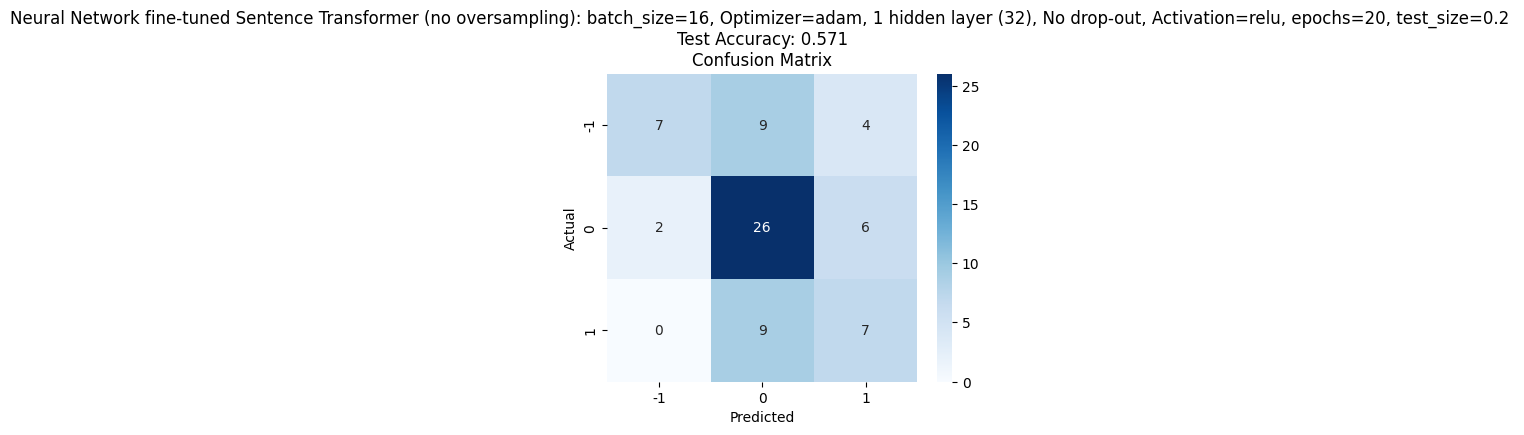

In [61]:
# Show Confusion matrix
plot_confusion_matrix(f"{best_title_nn} \nTest Accuracy: {best_acc_nn:.3f}", best_y_test, best_y_test_pred)

* The correct predictions on the diagonal sum 40, out of 70 test observations.

In [62]:
# Save the final results
model_eval_results.to_csv('model_eval_results.csv', index=False)

## **Conclusions**

Based on the initial problem statement, the goal was to use this sentiment analysis to potentially improve stock price predictions and investment strategies.

During the learning process, I experimented with model architectures, activation/loss functions, hyperparameters and their corresponding model outputs. The sentiment analysis models based on news content yielded several key findings:

* **Embedding Comparison**: Sentence transformers consistently outperformed Word2Vec when used with both Random Forest and Neural Network models.
* **Sentence Transformer Fine-tuning**: Fine-tuning the Sentence Transformer model on the provided news data resulted in a modest improvement in performance, although not as significant as initially anticipated.
* **Model Experimentation**: We explored various modeling approaches using the fine-tuned sentence transformer embeddings:
  * **Neural Networks**: Multiple adjustments to Neural Network parameters (epochs, batch size, layers, neurons, optimization, dropout, regularization, activation functions) were attempted. However, these often led to overfitting on the training data and underfitting on the test data.
  * **Random Forest**: A Grid Search was performed to fine-tune the hyperparameters of the Random Forest model, which improved test set metrics but also resulted in overfitting on the training data.
  * **Classic ML Classifiers**: Evaluating several classic machine learning classifiers revealed that Random Forest offered the best balance of accuracy and F1-score on the test data, although overfitting on the training data remained a challenge for most of these models.
* **Impact of Oversampling**: In this specific case, not using oversampling on the training data seemed to lead to slightly better performance on the test set across several models.

* **Final results**:
  * The best accuracy on test data was .571 using Random Forest algorithm on the GridSearch hyper-parameters, plus the fine-tuned Sentence Transformer embeddings and no oversampling train data; however, it overfitted on train data at 1.0 accuracy.

  * On the other side, tied as the best accuracy on test data was .571 using a Neural Network on fine-tuned Sentence Transformer (no oversampling): batch_size=32, Optimizer=adam, 1 hidden layer (32), No drop-out, Activation=relu, epochs=20. It overfitted train data at a much better accuracy of .845.

## **Recommendations**


**Get more data**: I mean more news and complete paragrapfs per news (without truncating content). More data would help the model refinement and avoid overfitting until reaching an acceptable solution.

**Use daily sentiment as a feature for stock price prediction**: We could build models that attempt to predict stock prices or price movements using a combination of historical stock data (time-series) and the daily sentiment labels (as apparently was shown during the EDA).

Thank you


---


Jose Quinonez


